In [1]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')
!ls
%cd gdrive/My\ Drive/colorectal_64/
!ls

Mounted at /content/gdrive
gdrive	sample_data
/content/gdrive/My Drive/colorectal_64
color_eval_augment._rgb.ipynb		 displayGeneratedImage_64641.ipynb
color_eval_origin_64641_ImageGene.ipynb  gan_training
color_eval_origin_64641.ipynb		 hmnist_64_64_L.csv
color_eval_origin_64641.ipynb（副本）	 images
cwgan-gp-color_64641.ipynb		 model_64_64_1.png


CGAN to generate data

In [2]:
# importing the libraries

import numpy as np 
import pandas as pd 

# from tensorflow import keras
# # from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
# # from keras.models import Sequential
# # from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,Flatten
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

#from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import confusion_matrix

In [3]:
#data = pd.read_csv("../input/hmnist_64_64_L.csv")      # reading the data
data = pd.read_csv("./hmnist_64_64_L.csv")      # reading the data

In [4]:
Y = data["label"]
data.drop(["label"],axis=1, inplace=True)
X = data

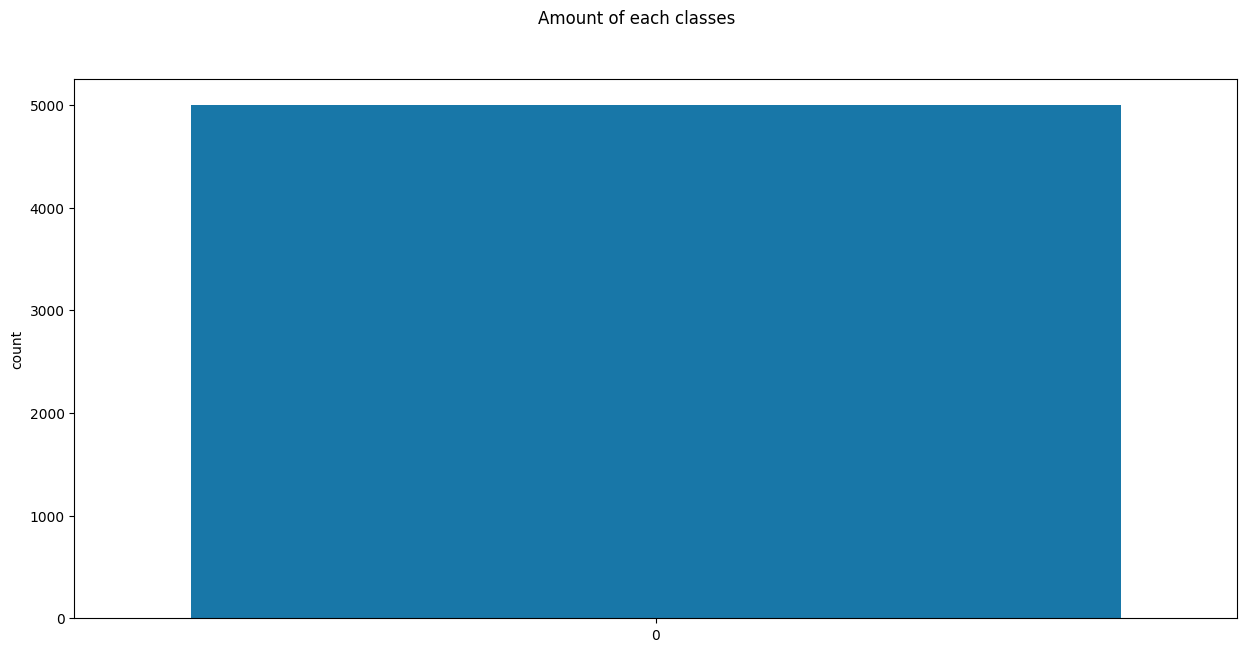

In [5]:
# creating the countplot

plt.figure(figsize=(15,7))
g = sns.countplot(Y, palette="winter_r")
plt.suptitle("Amount of each classes")
plt.show()

In [6]:
# it is very well balanced
Y.value_counts()  

2    625
5    625
7    625
6    625
8    625
1    625
4    625
3    625
Name: label, dtype: int64

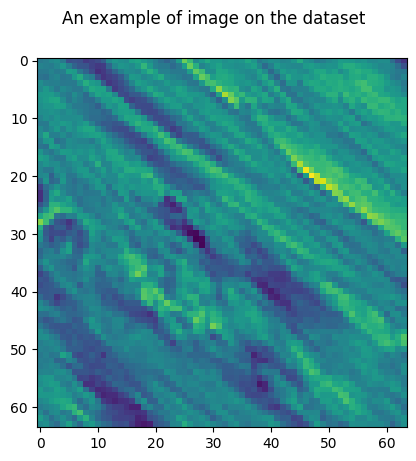

In [7]:
#img = X.iloc[75].as_matrix()  #old
img = X.iloc[70].to_numpy()  #leon, new
img = img.reshape(64,64,1)
plt.imshow(img)
plt.suptitle("An example of image on the dataset")
plt.show()

In [8]:
# Reshaping
img_size=64
IMG_SHAPE = (64, 64, 1)
channel = 1
# X = X.values.reshape(-1,28,28,1)       # shaping for the Keras
# Y = Y.values

In [9]:
# Splitting train and test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
# normalize
x_train = (x_train - 127.5) / 127.5
x_train = x_train.astype("float32") / 255.0
x_train = np.array(x_train).reshape(-1, img_size, img_size, channel)

x_test = (x_test - 127.5) / 127.5
x_test = x_test.astype("float32") / 255.0
x_test = np.array(x_test).reshape(-1, img_size, img_size, channel)

# x_train = x_train.reshape(x_train.shape[0], *IMG_SHAPE).astype("float32")
# x_train = np.reshape(x_train, (-1, img_size, img_size, 1))
#all_digits = all_digits.astype("float32") / 255.0
# x_train = np.reshape(x_train, (-1, img_size, img_size, 1))


#label-1 to match one hot encoder
y_train = y_train - 1  
y_test = y_test - 1

print(y_train.value_counts())
y_train = np.array(y_train)
y_test = np.array(y_test)


5    513
3    510
6    507
7    499
4    496
0    496
2    495
1    484
Name: label, dtype: int64


In [10]:
print("x_train.shape: ",x_train.shape)
print("x_test.shape: ",x_test.shape)
print("y_train.shape: ",y_train.shape)
print("y_test.shape: ",y_test.shape)
# print(x_train[0:5])


x_train.shape:  (4000, 64, 64, 1)
x_test.shape:  (1000, 64, 64, 1)
y_train.shape:  (4000,)
y_test.shape:  (1000,)


CWGAN-GP

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [12]:
# IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 128 #512

num_channels = 1
num_classes = 8  #10
image_size = 64

# Size of the noise vector
noise_dim = 128

# # fashion_mnist = keras.datasets.fashion_mnist
# mnist = keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# print(f"Number of examples: {len(train_images)}")
# print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# # Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
# train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
# train_images = (train_images - 127.5) / 127.5

# all_digits = train_images
# all_labels = train_labels

# Scale the pixel values to [0, 1] range, add a channel dimension to
# the images, and one-hot encode the labels.
#all_digits = all_digits.astype("float32") / 255.0
# all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

#all_labels = keras.utils.to_categorical(all_labels, 10)
y_train = keras.utils.to_categorical(y_train, 8)
# train_images = all_digits
# train_labels = all_labels

train_images = x_train
train_labels = y_train

generator_in_channels = noise_dim + num_classes
discriminator_in_channels = num_channels + num_classes  #conditonal

In [13]:
def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x

def get_discriminator_model():
    img_input = layers.Input(shape=(64, 64, discriminator_in_channels))
    # # Zero pad the input to make the input images size to (32, 32, 1).
    # x = layers.ZeroPadding2D((2, 2))(img_input)
    x = img_input
    x = conv_block(
        x,
        16,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        32,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )    
    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        256,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        512,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 9)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        3616      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        12832     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 64)        

In [14]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim + num_classes,))
    x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((4, 4, 256))(x)
    x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    x = upsample_block(
        x,
        32,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
    # x = upsample_block(
    #     x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    # )
    x = upsample_block(
        x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    # x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 136)]             0         
                                                                 
 dense_1 (Dense)             (None, 4096)              557056    
                                                                 
 batch_normalization (BatchN  (None, 4096)             16384     
 ormalization)                                                   
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 8, 8, 256)        0         
 )                                                       

In [15]:
import matplotlib.pyplot as plt
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

       
    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        # if isinstance(real_images, tuple):
        #     real_images = real_images[0]

        #print(real_images)
        real_images, one_hot_labels = real_images

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            # random_latent_vectors = tf.random.normal(
            #     shape=(batch_size, self.latent_dim)
            # )

            #########################################################################
            # Add dummy dimensions to the labels so that they can be concatenated with
            # the images. This is for the discriminator.
            image_one_hot_labels = one_hot_labels[:, :, None, None]
            image_one_hot_labels = tf.repeat(
                image_one_hot_labels, repeats=[image_size * image_size]
            )
            image_one_hot_labels = tf.reshape(
                image_one_hot_labels, (-1, image_size, image_size, num_classes)
            )

            # Sample random points in the latent space and concatenate the labels.
            # This is for the generator.
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_labels = tf.concat(
                [random_latent_vectors, one_hot_labels], axis=1
            )

            # Decode the noise (guided by labels) to fake images.
            generated_images = self.generator(random_vector_labels)

            # Combine them with real images. Note that we are concatenating the labels
            # with these images here.
            fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
            # combined_images = tf.concat(
            #     [fake_image_and_labels, real_image_and_labels], axis=0
            # )

            # Assemble labels discriminating real from fake images.
            # labels = tf.concat(
            #     [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            # )
            #########################################################################

            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                #fake_images = self.generator(random_latent_vectors, training=True)
                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_image_and_labels, training=True)
                # Get the logits for the real images
                real_logits = self.discriminator(real_image_and_labels, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_image_and_labels, fake_image_and_labels)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        ###########################################################################################
        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        #print('random_latent_vectors.shape', random_latent_vectors.shape)

        # Assemble labels that say "all real images".
        misleading_labels = tf.zeros((batch_size, 1))
        ###########################################################################################

        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            #generated_images = self.generator(random_latent_vectors, training=True)
            generated_images = self.generator(random_vector_labels, training=True)

            generated_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_image_and_labels, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(misleading_labels, gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

       

        return {"d_loss": d_loss, "g_loss": g_loss}

In [16]:
class GANMonitor(keras.callbacks.Callback):  #called by keras callback
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        #one_hot_labels = tf.reshape(tf.convert_to_tensor([self.num_img * [[1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]]]), (self.num_img, num_classes)) #10 classes
        one_hot_labels = tf.reshape(tf.convert_to_tensor([self.num_img * [[0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]]]), (self.num_img, num_classes)) #leon 8 classes class 4
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )
        generated_images = self.model.generator(random_vector_labels)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save("gan_training/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))
        
        # #leon plot picture for the process
        # plt.figure(figsize=(10,5))
        # plt.title("Generator and Discriminator Loss")
        # plt.plot(g_loss,label="Generator")
        # plt.plot(d_loss,label="Discriminator")
        # plt.xlabel("iterations")
        # plt.ylabel("Loss")
        # plt.legend()
        # plt.show()
        # #

In [17]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
# def generator_loss(fake_img):
#     #return -tf.reduce_mean(fake_img)
#     return -keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(misleading_labels, predictions):
    #return -tf.reduce_mean(fake_img)
    return -keras.losses.BinaryCrossentropy(from_logits=True)(misleading_labels, predictions)


# Set the number of epochs for trainining.
epochs = 50

# Instantiate the customer `GANMonitor` Keras callback.
# cbk = GANMonitor(num_img=3, latent_dim=noise_dim)
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=3,
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

# Start training the model.
history = wgan.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
# wgan.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])
#wgan.fit(dataset, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])



Epoch 1/50
32/32 [==============================] - 31s 336ms/step - d_loss: -1.9116 - g_loss: -0.0991
Epoch 2/50
32/32 [==============================] - 10s 306ms/step - d_loss: -11.4223 - g_loss: -1.6102e-15
Epoch 3/50
32/32 [==============================] - 10s 310ms/step - d_loss: -23.5068 - g_loss: -1.0909e-19
Epoch 4/50
32/32 [==============================] - 10s 317ms/step - d_loss: -36.0276 - g_loss: -2.4967e-21
Epoch 5/50
32/32 [==============================] - 10s 315ms/step - d_loss: -47.4063 - g_loss: -3.0930e-19
Epoch 6/50
32/32 [==============================] - 10s 322ms/step - d_loss: -55.5916 - g_loss: -4.1986e-19
Epoch 7/50
32/32 [==============================] - 10s 320ms/step - d_loss: -64.6736 - g_loss: -8.6232e-19
Epoch 8/50
32/32 [==============================] - 10s 322ms/step - d_loss: -69.0534 - g_loss: -3.3174e-18
Epoch 9/50
32/32 [==============================] - 11s 331ms/step - d_loss: -74.4248 - g_loss: -2.6270e-17
Epoch 10/50
32/32 [==============

<Figure size 640x480 with 0 Axes>

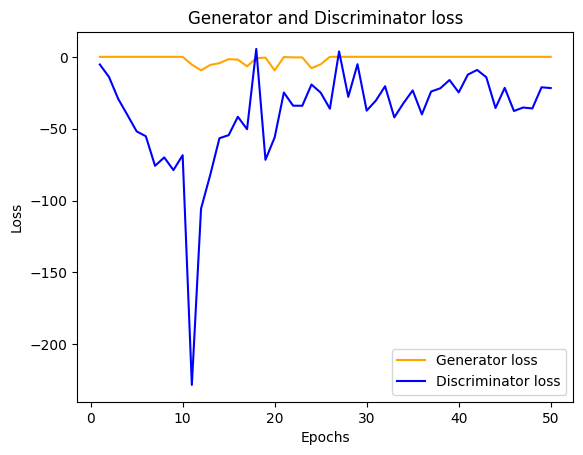

<Figure size 640x480 with 0 Axes>

In [18]:
# print(wgan.d_loss_fn)


# fig = plt.figure()
# plt.plot([x[0] for x in wgan.d_loss_fn], color='black', linewidth=0.25)
# plt.plot([x[1] for x in wgan.g_loss], color='green', linewidth=0.25)
# # plt.plot([x[2] for x in d_loss_fn, color='red', linewidth=0.25)
# # plt.plot(g_loss_fn, color='orange', linewidth=0.25)

# plt.xlabel('batch', fontsize=18)
# plt.ylabel('loss', fontsize=16)

# # plt.xlim(0, 2000)
# # plt.ylim(0, 2)

# plt.show()


#display loss, accuracy
d_loss_p = history.history['d_loss']
g_loss_p = history.history['g_loss']
epochs = range(1, len(d_loss_p) + 1)
# plt.plot(epochs,g_loss_p, 'bo', label = 'Generator loss')
# plt.plot(epochs,d_loss_p, 'b', label = 'Discriminator loss')
plt.plot(epochs,g_loss_p, 'orange', label = 'Generator loss')
plt.plot(epochs,d_loss_p, 'blue', label = 'Discriminator loss')
plt.title('Generator and Discriminator loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()


Generate images

generated_images 250
Generate:  (250, 64, 64, 1) <class 'tensorflow.python.framework.ops.EagerTensor'>
Saved X
Saved Y


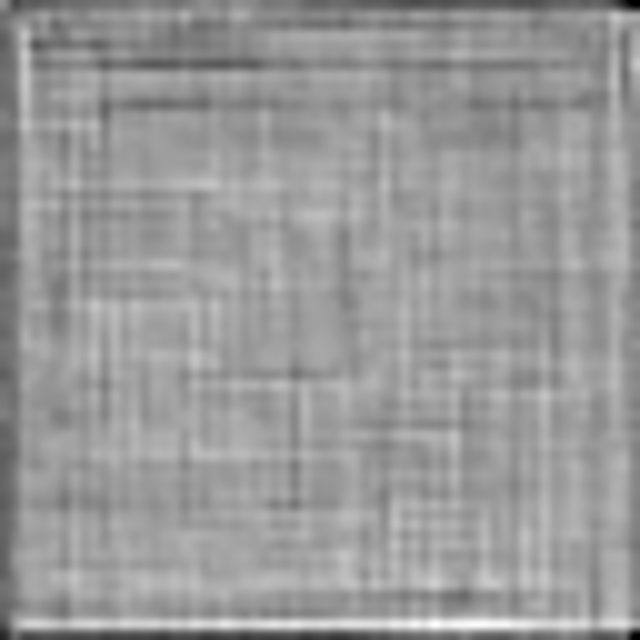

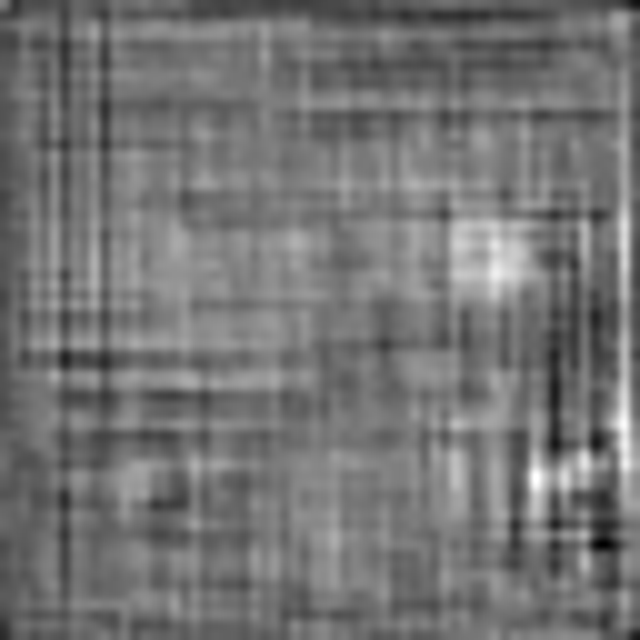

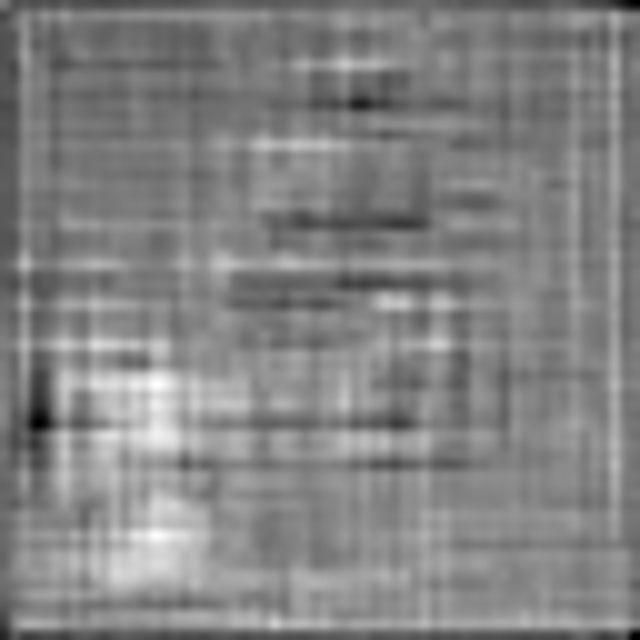

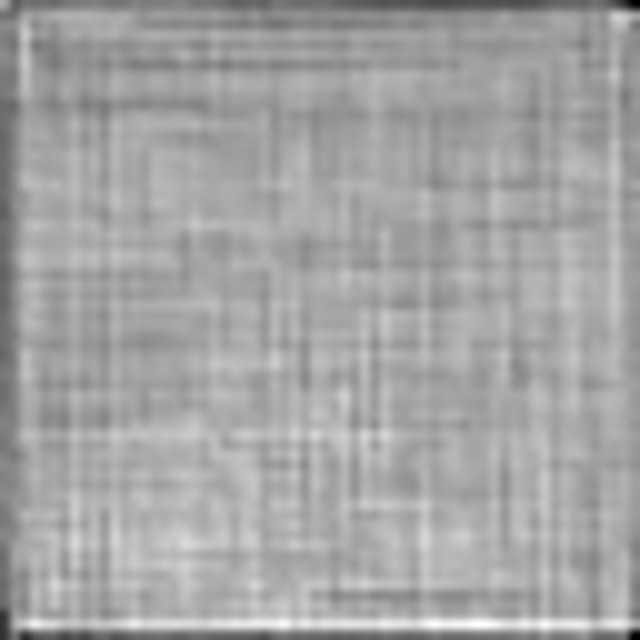

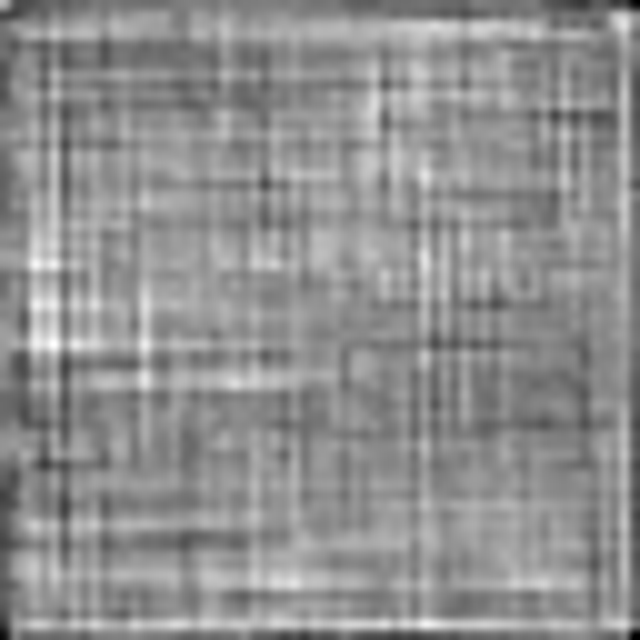

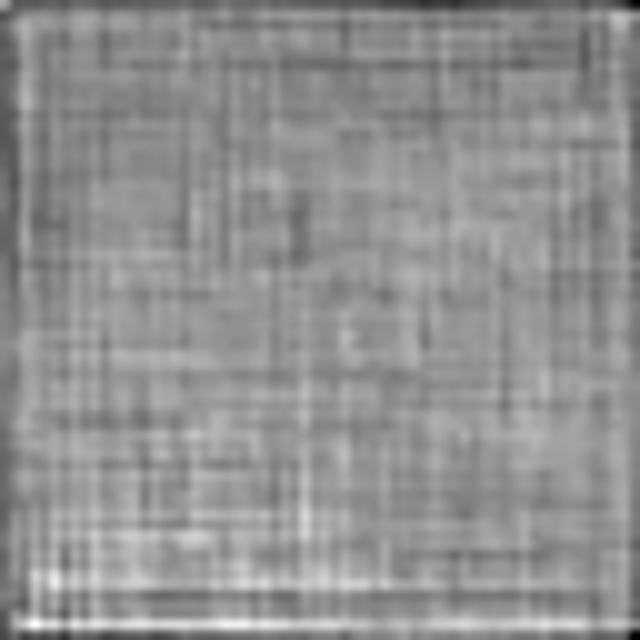

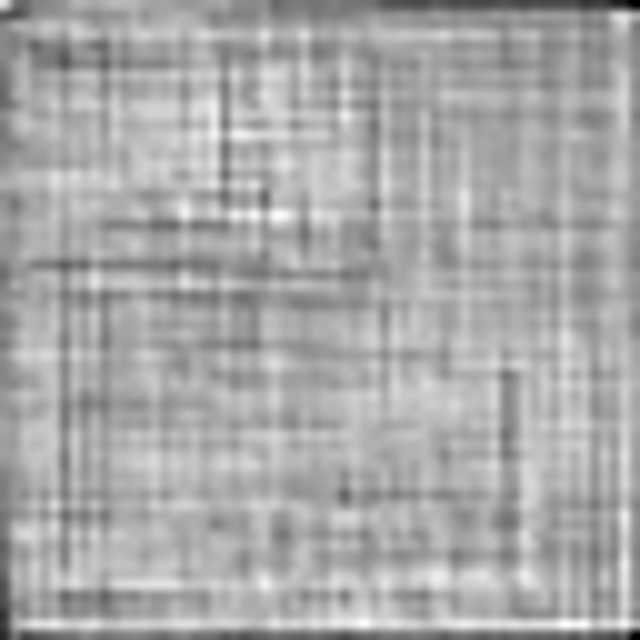

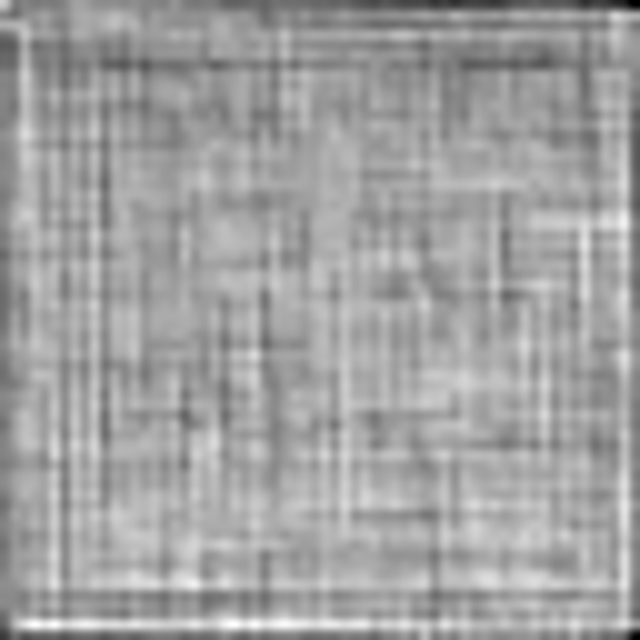

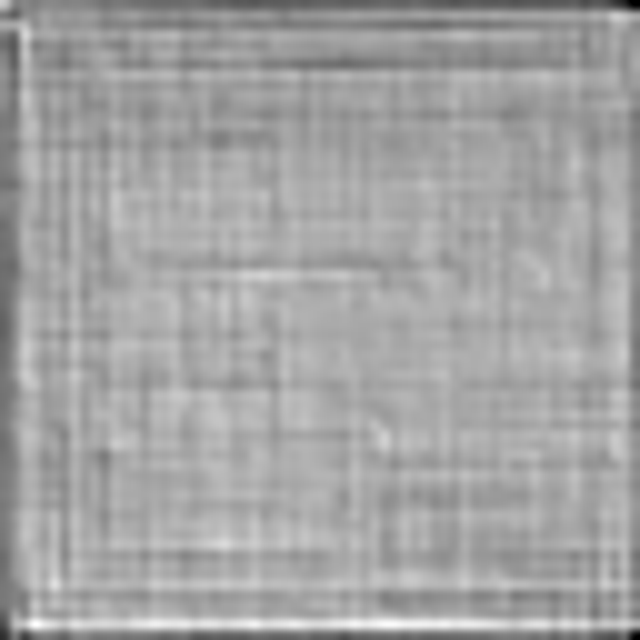

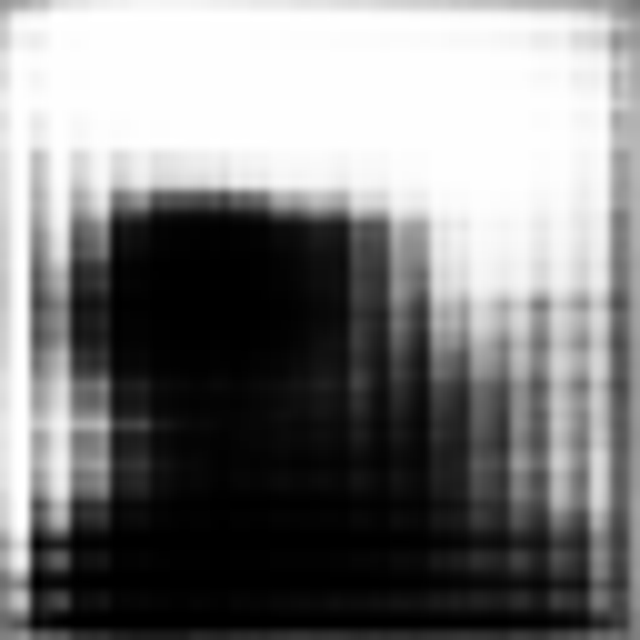

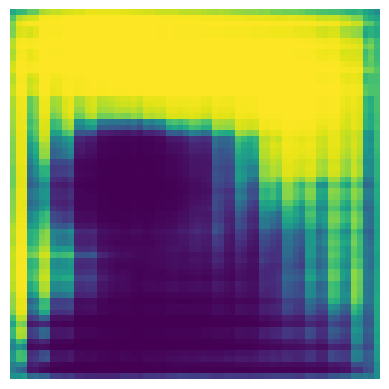

In [19]:
from IPython.display import display
from PIL import Image
import sys

num_example_images = 250  #number of generated image 
num_latent_dim = 128
label = 4  #for class 4(5-debris)

random_latent_vectors = tf.random.normal(shape=(num_example_images, num_latent_dim))
one_hot_labels = tf.reshape(tf.convert_to_tensor(
    # [num_example_images * [[0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0]]]), #Create synthetic '6'
    #                         (num_example_images, num_classes))    #old
    [num_example_images * [[0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,]]]), #Create synthetic class 2
                            (num_example_images, num_classes))
random_vector_labels = tf.concat(
    [random_latent_vectors, one_hot_labels], axis=1
)
generated_images = wgan.generator(random_vector_labels)
generated_images = (generated_images * 127.5) + 127.5

print("generated_images", len(generated_images))
print ("Generate: ", generated_images.shape, type(generated_images))

#sys.exit(0)
#old
#img = generated_images[0].numpy()
#img = keras.preprocessing.image.array_to_img(img)
#

# Save images to file
np.save(('images/x_train_class_%d.npy' % label), generated_images)
print ("Saved X")
y = np.zeros(generated_images.shape[0])
y[:] = label
np.save(('images/y_train_class_%d.npy' % label), y)
print ("Saved Y")


#plt.clf()
scale = 10  # enlarge 10 times

for i in range(10): #range(len(generated_images)-1):   # To create all required images, range(len(generatedImages)+1))
  img = generated_images[i].numpy()
  img = keras.preprocessing.image.array_to_img(img)
  #plt.imshow(generated_images[i], cmap='gray') #leon
  plt.imshow(generated_images[i]) #leon
  plt.axis('off')
  #plt.savefig('images/%d.png' % i)
  img.save('images/%d.png' % i)
  image = Image.open('images/%d.png' % i)
  
  display(image.resize(( int(image.width * scale), int(image.height * scale))))

# Save file for display
#img.save("example.png")

#image = Image.open("example.png")
#scale = 10
#display(image.resize(( int(image.width * scale), int(image.height * scale))))

In [20]:
# Save the generator and discriminator networks (and weights) for later use
def saveModels(epoch):
    generator.save('models/dcgan_generator_epoch_%d.h5' % epoch)
    discriminator.save('models/dcgan_discriminator_epoch_%d.h5' % epoch)

In [21]:
# # Create a dataset of final generated images
# def create_dataset(examples, dim=(10, 10), figsize=(10, 10)):
#     noise = np.random.normal(0, 1, size=[examples, num_latent_dim])
#     generatedImages = wgan.generator.predict(noise)
#     print ("Generate: ", generatedImages.shape, type(generatedImages))

#     # Save images to file
#     np.save(('images/x_train_class_%d.npy' % label), generatedImages)
#     print ("Saved X")

#     y = np.zeros(generatedImages.shape[0])
#     y[:] = label
#     np.save(('images/y_train_class_%d.npy' % label), y)
#     print ("Saved Y")

#     # Plot some images
#     plt.clf()
#     for i in range(10):   # To create all required images, range(len(generatedImages)+1))
#         #plt.imshow(generatedImages[i, 0], cmap='gray_r')
#         plt.imshow(generatedImages[i, 0], cmap='gray') #leon
#         plt.axis('off')
#         plt.savefig('images/%d.png' % i)
